# Часть 4. Feature engiering

Из прошлой части у нас есть подготовленный набор данных, на котором мы построили простую модель.  
В этой части попробуем добавить новые фичи для обучения.

In [1]:
import json
import pickle
from functools import partial

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from scipy.sparse import hstack

Сделаем настройки ноутбука

In [2]:
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams['figure.figsize'] = 12, 8
RANDOM_STATE=43

## Прочитаем набор полученный на предыдущем шаге

In [3]:
df = pd.read_csv('data1.csv')
print(f"{df.shape=}")

df.shape=(70896, 34)


C:\Soft\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Определим функции для дальнейшего анализа

* `fit_and_score_model` - оценивает переданнух модель на кросс валидации, и выводит среднее значение метрики `mape`
* `make_submit` - делает предсказание модели на тестовых данныхЪ и сохраняет их в файл `predict.csv`
* `prepare_data` - подгаталивает тренировочный и тестовый набор (на основании переданного списка колонок)

In [4]:
def mape(y_true, y_pred):
    """оценка MEAN ABSOLUTE PERCENTAGE ERROR, которая используется в соревновании"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    
def fit_and_score_model(model, X, y):
    """Оцениваем модель и данные на трех фолдах. Выводим средюю оценку, и оценки на фолдах"""
    
    kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    cv_results = cross_val_score(
        model, X, y, cv=kf, n_jobs=-1, scoring=make_scorer(mape))
    
    model.fit(X_train,y)
    train_score = mape(y, model.predict(X_train))
    
    print("#"*100)
    print(model)
    print(f"train shape {X.shape}")
    print(f"{cat_cols=}")
    print(f"{num_cols=}")
    print("#"*100)
    print(f"Train result: {train_score}")
    print(f'CV result: {np.mean(cv_results)} ({cv_results})')
    print("#"*100)


def make_submit_file(model, X_test, file_name='predict.csv'):
    """запишем предсказание модели в файл, готовый к отправке на kaggle"""
    pred = np.round(model.predict(X_test))
    answer = pd.Series(pred, index=df[~df.is_train].sell_id, name='price')
    answer.to_csv(file_name, index_label='sell_id')


def prepare_data(categorical_columns: list, numerical_columns: list):
    """Вытащим требуемые данные из глобальной переменной df
    к категориальным применим dummy кодирование
    к числовым Шкалирование"""
    X = df.loc[:, categorical_columns+numerical_columns+['is_train']]

    X = pd.get_dummies(X, columns=categorical_columns)
    X[numerical_columns] = StandardScaler().fit_transform(X[numerical_columns])
    
    X_train = X[X.is_train == 1].drop('is_train', axis=1)
    X_test = X[X.is_train == 0].drop('is_train', axis=1)

    y = df[df.is_train].price

    return X_train, X_test, y

# Попробуем модель случайный лес

Попробуем модель случайный лес на имеющихся данных, и будем ее считать как начальный бейзлайн для дальнейшей работы с данными  
Случайный лес достаточно универсальная модель, которая к тому же показывает важность наших фич

In [5]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols = ['productionDate', 'numberOfDoors',
            'engineDisplacement', 'mileage', ]

In [6]:
X_train, X_test, y = prepare_data(cat_cols, num_cols)

In [7]:
model = RandomForestRegressor(100, random_state=RANDOM_STATE)

In [ ]:
%%time
fit_and_score_model(model, X_train, y)

Неплохие начальные результаты.  
Посмотрим на важные признаки модели.

In [17]:
pd.Series(model.feature_importances_,
          index=X_train.columns).sort_values(ascending=False).iloc[:20]

mileage                              0.36
engineDisplacement                   0.31
productionDate                       0.08
model_name_G-КЛАСС AMG               0.04
model_name_MAYBACH S-КЛАСС           0.03
brand_MERCEDES                       0.03
vehicleTransmission_автоматическая   0.02
model_name_SLR MCLAREN               0.01
Привод_передний                      0.01
Привод_задний                        0.01
Привод_полный                        0.01
model_name_G-КЛАСС                   0.01
vendor_EUROPEAN                      0.01
vehicleTransmission_механическая     0.01
model_name_GLE                       0.01
vendor_JAPANESE                      0.00
bodyType_минивэн                     0.00
model_name_W188                      0.00
model_name_V-КЛАСС                   0.00
Владельцы_1 владелец                 0.00
dtype: float64

в тесте обнуружились пропуски, пока уберем таким костылем

In [18]:
X_test.engineDisplacement.fillna(df.engineDisplacement.mean(), inplace=True)

In [19]:
make_submit_file(model, X_test, "1_baseline_random_forest_100.csv")

**RandomForestRegressor(random_state=43)**  
CV mean_result: 14.63  
train mape 5.86  
kaggle submit 13.86826

# Сделаем небольшой EDA

Давайте исследуем наши данные еще раз, и попрбуем добавить новые фичи.  
План такой:  
* Посмотреть корреляцию данных
* Посмотреть пропуски если получиться и заполнить их
* Анализировать колонки

## Ищем корреляцию

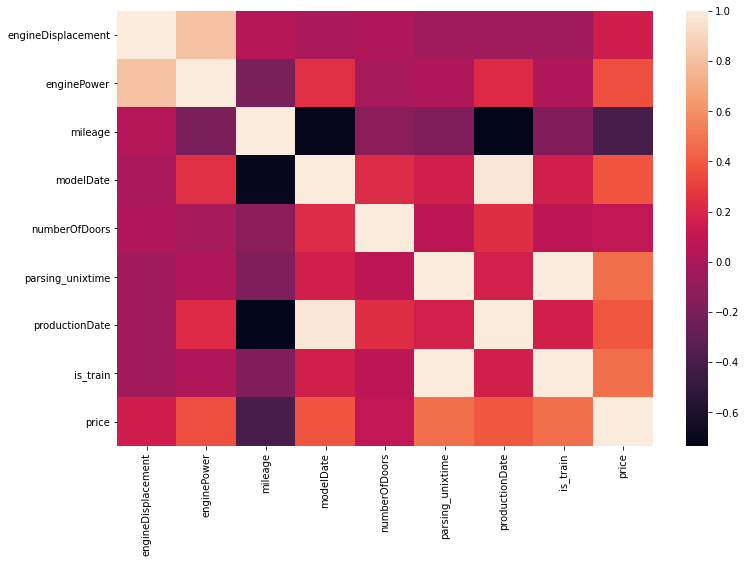

In [7]:
sns.heatmap(df.corr());

Выводы по диаграмме корреляции:  
- production_date коррелирует с model_date - оставляем ону колонку
- bp engine dicplacement коррелирует с engine power - оставляем одну колонку
- mileage отрицательно коррелрует с modelDate, productionDate и price

## Исследуем пропуски

In [8]:
df.isna().sum()

bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict      28268
description              1000
engineDisplacement         55
enginePower                 0
equipment_dict           9996
fuelType                    0
image                       0
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы                   0
Владение                49577
ПТС                         0
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
is_train                    0
price     

**Выводы:**  

* `complectation_dict`, `description`, `equipment_dict` - это поля, из которых мы будем получать доп.сведения (если успеем) пока пропуски в этих полях не используем (как и сами поля)  

* `engineDisplacement` надо заполнить, уже вылезло это в первой модели  

* `Владение` - пока не используем, но нужно будет поработать с этим полем отом

### Заполним пропуск engineDisplacement

посмотрим, какой тип топлива у незаполненных машин

In [9]:
df[df.engineDisplacement.isna()].fuelType.value_counts()

электро    55
Name: fuelType, dtype: int64

а у электро всегда ставят 0 объем

In [10]:
df[df.fuelType=='электро'].engineDisplacement.value_counts()

0.00    59
Name: engineDisplacement, dtype: int64

In [11]:
df.loc[df.fuelType=='электро','engineDisplacement'] = df.loc[df.fuelType=='электро','engineDisplacement'].fillna(0)

## price

Целевая колонка распределена лог-нормально.  
Возможно стоит ее логарифмировать в будующем.  
Но пока оставим это как есть. Может быть потом будет использовать

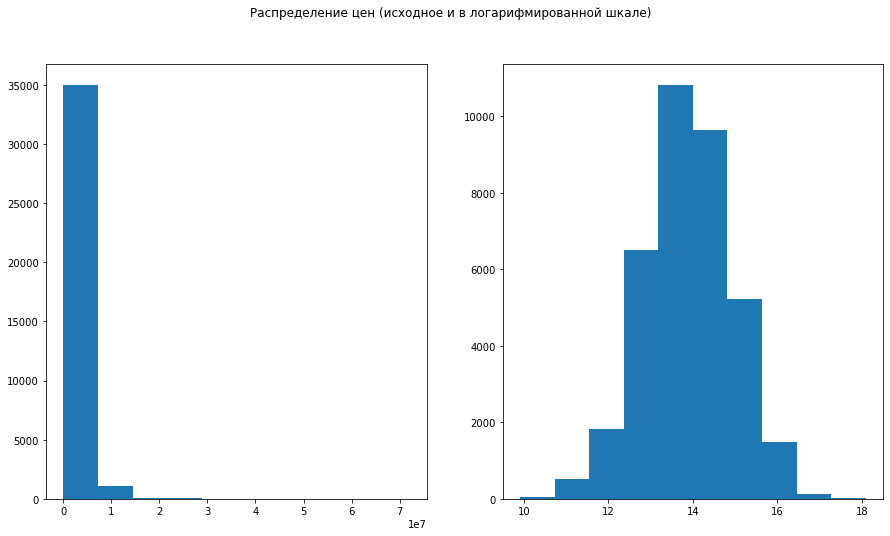

In [12]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.hist(df[df.is_train==1].price)
ax2.hist(np.log(df[df.is_train==1].price))
figure.suptitle('Распределение цен (исходное и в логарифмированной шкале)')
plt.show()

In [19]:
df["price_log"] = np.log(df[df.is_train==1].price)

## bodyType

в колонке 25 значений, очень сильно по ним варьируется цена  
возможно стоит объединить все в более крупную схему (внедорожники все вместе, седаны, хетчбеки) - нужно проверить идею

In [13]:
df.bodyType.value_counts()

внедорожник 5 дв.          28277
седан                      24621
лифтбек                     4924
хэтчбек 5 дв.               3884
универсал 5 дв.             2490
минивэн                     1754
купе                        1578
компактвэн                   928
хэтчбек 3 дв.                855
пикап двойная кабина         569
внедорожник 3 дв.            248
купе-хардтоп                 217
кабриолет                    170
родстер                      150
фургон                       144
микровэн                      22
седан-хардтоп                 15
седан 2 дв.                   12
пикап одинарная кабина        11
лимузин                        9
пикап полуторная кабина        7
тарга                          4
внедорожник открытый           4
фастбек                        2
универсал 3 дв.1               1
Name: bodyType, dtype: int64

In [14]:
df.groupby(['bodyType', 'is_train'])['price'].agg(
    ['count', 'min', 'mean', 'max'])

count       min          mean       max
bodyType                is_train                                         
внедорожник 3 дв.       False       115         0          0.00         0
                        True        133    100000    455,878.29   3500000
внедорожник 5 дв.       False     12228         0          0.00         0
                        True      16049     79000  2,458,984.44  29300000
внедорожник открытый    False         3         0          0.00         0
                        True          1  15000000 15,000,000.00  15000000
кабриолет               False        90         0          0.00         0
                        True         80    470000  2,016,779.79  14781200
компактвэн              False       489         0          0.00         0
                        True        439     80000    574,575.83   2233100
купе                    False       824         0          0.00         0
                        True        754     70000  2,226,653.66  72000000
купе-хардтоп            False       158         0          0.00         0
                        True         59    230000  1,479,630.51   5200000
лимузин                 False         6         0          0.00         0
                        True          3   3500000  5,496,666.67   8000000
лифтбек                 False      2232         0          0.00         0
                        True       2692     27000    979,420.04  16650000
микровэн                False         7         0          0.00         0
                        True         15    140000    359,266.67    950000
минивэн                 False       995         0          0.00         0
                        True        759     60000  2,238,321.49  25500000
пикап двойная кабина    False       280         0          0.00         0
                        True        289    110000  1,458,609.65  12850000
пикап одинарная кабина  False         5         0          0.00         0
                        True          6    160000  1,784,166.67   4400000
пикап полуторная кабина False         5         0          0.00         0
                        True          2    399999  2,549,999.50   4700000
родстер                 False        99         0          0.00         0
                        True         51    295000  2,202,460.47  22500000
седан                   False     13147         0          0.00         0
                        True      11474     20000  1,420,625.03  58997576
седан 2 дв.             False         6         0          0.00         0
                        True          6    110000  1,058,333.33   2500000
седан-хардтоп           False        12         0          0.00         0
                        True          3     80000    200,000.00    370000
тарга                   False         2         0          0.00         0
                        True          2    120000    260,000.00    400000
универсал 3 дв.1        True          1    200000    200,000.00    200000
универсал 5 дв.         False      1276         0          0.00         0
                        True       1214     20000    893,912.74   6449000
фастбек                 False         1         0          0.00         0
                        True          1    598000    598,000.00    598000
фургон                  False        97         0          0.00         0
                        True         47    130000    674,102.02   2616600
хэтчбек 3 дв.           False       485         0          0.00         0
                        True        370     30000    412,978.25   2900000
хэтчбек 5 дв.           False      2124         0          0.00         0
                        True       1760     23000    550,573.39   6710400

In [15]:
bodyTypes = {
    'внедорожник открытый':'внедорожник',
    'внедорожник 5 дв.':'внедорожник',
    'седан':'седан',
    'лифтбек':'хэтчбек',
    'хэтчбек 5 дв.':'хэтчбек',
    'универсал 5 дв.':'универсал',
    'минивэн':'минивэн',
    'купе':'купе',
    'компактвэн':'минивэн',
    'хэтчбек 3 дв.':'хэтчбек',
    'пикап двойная кабина':'пикап',
    'внедорожник 3 дв.':'внедорожник',
    'купе-хардтоп':'купе',
    'кабриолет':'кабриолет',
    'родстер':'родстер',
    'фургон':'фургон',
    'микровэн':'минивэн',
    'седан-хардтоп':'седан',
    'седан 2 дв.':'седан',
    'пикап одинарная кабина':'пикап',
    'лимузин':'лимузин',
    'пикап полуторная кабина':'пикап',
    'внедорожник открытый':'внедорожник',
    'тарга':'родстер',
    'фастбек':'хэтчбек',
    'универсал 3 дв.1':'универсал',

}
df['bodyType_cut'] = df.bodyType.map(bodyTypes)


In [16]:
df.groupby(['bodyType_cut', 'is_train'])['price'].agg(
    ['count', 'min', 'mean', 'max'])

count      min         mean       max
bodyType_cut is_train                                       
внедорожник  False     12346        0         0.00         0
             True      16183    79000 2,443,296.86  29300000
кабриолет    False        90        0         0.00         0
             True         80   470000 2,016,779.79  14781200
купе         False       982        0         0.00         0
             True        813    70000 2,172,441.64  72000000
лимузин      False         6        0         0.00         0
             True          3  3500000 5,496,666.67   8000000
минивэн      False      1491        0         0.00         0
             True       1213    60000 1,612,954.49  25500000
пикап        False       290        0         0.00         0
             True        297   110000 1,472,535.98  12850000
родстер      False       101        0         0.00         0
             True         53   120000 2,129,160.08  22500000
седан        False     13165        0         0.00         0
             True      11483    20000 1,420,116.83  58997576
универсал    False      1276        0         0.00         0
             True       1215    20000   893,341.61   6449000
фургон       False        97        0         0.00         0
             True         47   130000   674,102.02   2616600
хэтчбек      False      4842        0         0.00         0
             True       4823    23000   779,392.05  16650000

Объединили машины в новый классификатор из 11 классов.  
Попробуем потом как он покажет себя в модели.

## enginePower

Т.к. поля engine power и engine displacement - очень скоррелированы то нужно выбрать одно.  
у поля engine power есть преимущество, оно не равно 0 для электрокаров  
и расрпделение лог-нормально, можно прологарифмировать его

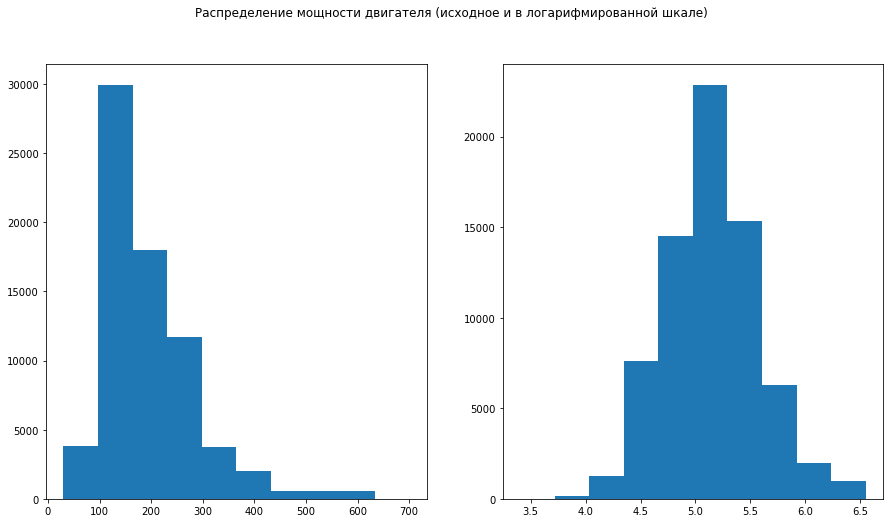

In [12]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.hist(df.enginePower)
ax2.hist(np.log(df.enginePower))
figure.suptitle('Распределение мощности двигателя (исходное и в логарифмированной шкале)')
plt.show()

In [28]:
df['enginePower_log'] = np.log(df.enginePower)

## mileage

Поле конечно очень сильно влияет на цену авто.  
Отдельной категорией идут автомобили без пробега - выделим их отдельно  
и прологорифмируем колонку

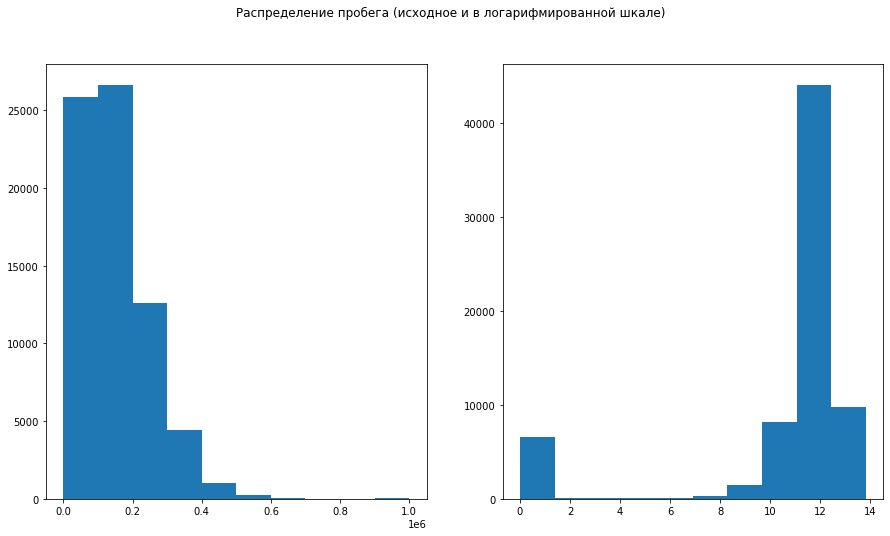

In [14]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.hist(df.mileage)
ax2.hist(np.log(df.mileage+1))
figure.suptitle('Распределение пробега (исходное и в логарифмированной шкале)')
plt.show()

In [30]:
df['mileage_is_0'] = (df.mileage == 0)
df['mileage_log'] = np.log(df.mileage+1)

## Оформим все в одну функцию
чтобы удобней было переиспользовать ноутбук позже

In [6]:
def feature_enginering_version1(df: pd.DataFrame):
    """запишем сюда все преобразования которые делали в этом разделе ноутбука
    1) заполнили пропуски в поле engineDisplacement для электрокаров
    2) сделали колонку логарифм цены
    3) сделали свернутую колонки тип кузова bodyType_cut
    4) сделали признак enginePower_log - логарифм от мощности двигателя
    5) сделали признак пробег равен 0 mileage_is_0
    6) сделали признак логарифм от пробега"""
    
    df.loc[df.fuelType == 'электро',
           'engineDisplacement'] = df.loc[df.fuelType == 'электро',
                                          'engineDisplacement'].fillna(0)

    df["price_log"] = np.log(df[df.is_train==1].price)
    
    bodyTypes = {
        'внедорожник открытый': 'внедорожник',
        'внедорожник 5 дв.': 'внедорожник',
        'седан': 'седан',
        'лифтбек': 'хэтчбек',
        'хэтчбек 5 дв.': 'хэтчбек',
        'универсал 5 дв.': 'универсал',
        'минивэн': 'минивэн',
        'купе': 'купе',
        'компактвэн': 'минивэн',
        'хэтчбек 3 дв.': 'хэтчбек',
        'пикап двойная кабина': 'пикап',
        'внедорожник 3 дв.': 'внедорожник',
        'купе-хардтоп': 'купе',
        'кабриолет': 'кабриолет',
        'родстер': 'родстер',
        'фургон': 'фургон',
        'микровэн': 'минивэн',
        'седан-хардтоп': 'седан',
        'седан 2 дв.': 'седан',
        'пикап одинарная кабина': 'пикап',
        'лимузин': 'лимузин',
        'пикап полуторная кабина': 'пикап',
        'внедорожник открытый': 'внедорожник',
        'тарга': 'родстер',
        'фастбек': 'хэтчбек',
        'универсал 3 дв.1': 'универсал',
    }
    df['bodyType_cut'] = df.bodyType.map(bodyTypes)

    df['enginePower_log'] = np.log(df.enginePower)

    df['mileage_is_0'] = (df.mileage == 0)
    df['mileage_log'] = np.log(df.mileage + 1)

In [7]:
feature_enginering_version1(df)

## Попробуем новые признаки в предсказании

In [32]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols = ['productionDate', 'numberOfDoors',
            'engineDisplacement', 'mileage', ]

In [10]:
model = RandomForestRegressor(100, random_state=RANDOM_STATE)

### price_log

In [13]:
X_train, X_test, y = prepare_data(cat_cols, num_cols)
y_log = df[df.is_train].price_log

X_train, X_val, y_train, y_val, y_log_train, y_log_val = train_test_split(
    X_train, y, y_log, test_size=0.3, shuffle=True, random_state=RANDOM_STATE)

In [14]:
%%time
model.fit(X_train, y_train)
pred = model.predict(X_val)
score = mape(pred, y_val)
print(f"MAPE: {score}")

MAPE: 13.604938740548983
Wall time: 1min 22s


In [15]:
%%time
model.fit(X_train, y_log_train)
pred = np.exp(model.predict(X_val))
score = mape(pred, np.exp(y_log_val))
print(f"MAPE (+log price): {score}")

MAPE (+log price): 14.418258095834686
Wall time: 1min 17s


In [33]:
X_train, X_test, y = prepare_data(cat_cols, num_cols)

In [34]:
%%time
fit_and_score_model(model, X_train, y)

####################################################################################################
RandomForestRegressor(random_state=43)
train shape (36210, 812)
####################################################################################################
Train result: 5.856917872579963
CV result: 14.62884728522331 ([14.62107618 14.9227222  14.34274348])
####################################################################################################
Wall time: 3min 29s


Видим что логарифмирование цены только ухудщило нашу модель, поэтому не будем использовать.  
Хотя проверяли просто на отложенной выборке. Но наодной и той же выборкевариант без логарифмирования показал почти на 1% лучше результат.  

Еще интересно что результат на отложенной выборке оказался значительно лучше результата на кросвалидации (на всех трех фолдах).

### bodyType_cut

In [24]:
cat_cols = ['bodyType_cut', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols = ['productionDate', 'numberOfDoors',
            'engineDisplacement', 'mileage', ]

In [25]:
X_train, X_test, y = prepare_data(cat_cols, num_cols)

In [26]:
%%time
fit_and_score_model(model, X_train, y)


####################################################################################################
RandomForestRegressor(random_state=43)
train shape (36210, 798)
####################################################################################################
Train result: 5.842052653104446
CV result: 14.666090067331032 ([14.69846837 14.93388031 14.36592152])
####################################################################################################
Wall time: 3min 24s


In [27]:
cat_cols = ['bodyType_cut', 'bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols = ['productionDate', 'numberOfDoors',
            'engineDisplacement', 'mileage', ]

In [28]:
X_train, X_test, y = prepare_data(cat_cols, num_cols)

In [29]:
%%time
fit_and_score_model(model, X_train, y)

####################################################################################################
RandomForestRegressor(random_state=43)
train shape (36210, 823)
####################################################################################################
Train result: 5.831004862140472
CV result: 14.649151237479687 ([14.64214966 14.93764742 14.36765664])
####################################################################################################
Wall time: 3min 23s


Испльзование признака **bodyType_cut** не принесло пользы:   
- ни в варианте использование вместо bodyType   
- ни в впаринте использование вместе с bodyType   

Результат ухудшился оба раза   

### enginePower

In [16]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols = ['productionDate', 'numberOfDoors',
            'enginePower_log', 'mileage', ]

X_train, X_test, y = prepare_data(cat_cols, num_cols)

In [17]:
%%time
fit_and_score_model(model, X_train, y)

####################################################################################################
RandomForestRegressor(random_state=43)
train shape (36210, 812)
cat_cols=['bodyType', 'brand', 'fuelType', 'color', 'model_name', 'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols=['productionDate', 'numberOfDoors', 'enginePower_log', 'mileage']
####################################################################################################
Train result: 5.5776517016253475
CV result: 14.114852945022472 ([14.00237657 14.47699244 13.86518982])
####################################################################################################
Wall time: 3min 45s


Показатель **enginePower_log** помогает лучше нам предсказывать.

### milleage

In [7]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols = ['productionDate', 'numberOfDoors',
            'enginePower_log', 'mileage_log', ]

X_train, X_test, y = prepare_data(cat_cols, num_cols)

In [11]:
%%time
fit_and_score_model(model, X_train, y)

####################################################################################################
RandomForestRegressor(random_state=43)
train shape (36210, 814)
cat_cols=['bodyType', 'brand', 'fuelType', 'color', 'model_name', 'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль', 'mileage_is_0']
num_cols=['productionDate', 'numberOfDoors', 'enginePower_log', 'mileage_log']
####################################################################################################
Train result: 5.571616747005929
CV result: 14.10274449012581 ([13.99268869 14.4649319  13.85061288])
####################################################################################################
Wall time: 3min 43s


Показатель **mileage_log** тоже немножко улучшил нашу модель

### milleage_is_0

In [12]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль', 'mileage_is_0']
num_cols = ['productionDate', 'numberOfDoors',
            'enginePower_log', 'mileage_log', ]

X_train, X_test, y = prepare_data(cat_cols, num_cols)

In [13]:
%%time
fit_and_score_model(model, X_train, y)

####################################################################################################
RandomForestRegressor(random_state=43)
train shape (36210, 814)
cat_cols=['bodyType', 'brand', 'fuelType', 'color', 'model_name', 'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль', 'mileage_is_0']
num_cols=['productionDate', 'numberOfDoors', 'enginePower_log', 'mileage_log']
####################################################################################################
Train result: 5.571616747005929
CV result: 14.10274449012581 ([13.99268869 14.4649319  13.85061288])
####################################################################################################
Wall time: 3min 43s


In [14]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль', ]
num_cols = ['productionDate', 'numberOfDoors',
            'enginePower_log', 'mileage_log', 'mileage_is_0']

X_train, X_test, y = prepare_data(cat_cols, num_cols)

In [15]:
%%time
fit_and_score_model(model, X_train, y)

####################################################################################################
RandomForestRegressor(random_state=43)
train shape (36210, 813)
cat_cols=['bodyType', 'brand', 'fuelType', 'color', 'model_name', 'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols=['productionDate', 'numberOfDoors', 'enginePower_log', 'mileage_log', 'mileage_is_0']
####################################################################################################
Train result: 5.56687832682076
CV result: 14.105340374949934 ([13.98890007 14.50594714 13.82117391])
####################################################################################################
Wall time: 3min 31s


Показатель **mieage_is_0** никак не помог. Хотя может быть для других видов моделей (линейной) он бы был полезен.

# Исследуем данные дальше

## Линейная регрессия

Сделаем модель Лассо регрессии, чтобы посмотреть какие коэффицинты обнуляться

In [21]:
model = Lasso(alpha=3)

In [25]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль', 'mileage_is_0']
num_cols = ['productionDate', 'numberOfDoors',
            'enginePower_log', 'mileage_log', ]

X_train, X_test, y = prepare_data(cat_cols, num_cols)

In [26]:
%%time
fit_and_score_model(model, X_train, y)

C:\Soft\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8098870816394256e+16, tolerance: 19939787947380.223
  model = cd_fast.enet_coordinate_descent(


####################################################################################################
Lasso(alpha=3)
train shape (36210, 814)
cat_cols=['bodyType', 'brand', 'fuelType', 'color', 'model_name', 'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль', 'mileage_is_0']
num_cols=['productionDate', 'numberOfDoors', 'enginePower_log', 'mileage_log']
####################################################################################################
Train result: 60.18703438972369
CV result: 62.339911666038255 ([63.33971648 63.90626578 59.77375273])
####################################################################################################
Wall time: 1min 41s


In [28]:
coefs = pd.Series(model.coef_, index=X_train.columns)
print(coefs.shape)
coefs[coefs==0].index.values

(814,)


array(['bodyType_пикап полуторная кабина', 'bodyType_тарга',
       'color_бежевый', 'color_коричневый', 'color_пурпурный',
       'color_серебристый', 'model_name_02', 'model_name_100_SERIES',
       'model_name_120', 'model_name_140', 'model_name_190_SL',
       'model_name_1ER', 'model_name_200SX', 'model_name_240_SERIES',
       'model_name_2ACTIVETOURER', 'model_name_2ER',
       'model_name_2GRANDTOURER', 'model_name_3ER', 'model_name_4',
       'model_name_5ER', 'model_name_6ER', 'model_name_7ER',
       'model_name_8ER', 'model_name_A4_ALLROAD', 'model_name_ACTY',
       'model_name_ALLROAD', 'model_name_ALMERA_CLASSIC',
       'model_name_ALMERA_TINO', 'model_name_AMG_GLC_COUPE',
       'model_name_AMG_GT', 'model_name_ARTEON', 'model_name_ASPIRE',
       'model_name_AVALON', 'model_name_AVENSIS_VERSO', 'model_name_AYGO',
       'model_name_A_KLASSE', 'model_name_A_KLASSE_AMG',
       'model_name_BASSARA', 'model_name_BLUEBIRD_SYLPHY',
       'model_name_B_KLASSE', 'model_name

Линейная регрессия конечно очень плохо справилась, но зато можно посмотреть какие коэффициенты она обнулала.
Lasso регрессия обнулила 814 коэффициентов, в основном это dummy колонки по `model_name`

## model_name

В текущем наборе мы эту колонку сделали dummy колонкой и наша Lasso модель обнулила много коэффициентов по ней  
наверное стоит сделать ограничение на эту колонку, чтобы не засорять модель 733 новыми колонками  
определим, сколько моделей стоит учитывать  

увидел что в колонке есть значение с пробелами и с подчеркиваниями (наверное в тесте и в трейне разные парсеры) - исправим это  
думаю 50 моделей - нормальное число, как раз только 50 моделей встерчаются более 500 раз, остальные меньше

In [29]:
df.model_name = df.model_name.str.replace(' ', '_')

In [30]:
df.model_name.value_counts()[40:60]

S_KLASSE        549
GLE             536
YETI            529
FABIA           515
RAV4            515
SUPERB          514
PAJERO_SPORT    487
CR-V            466
JUKE            452
RAV_4           447
A3              446
MURANO          433
KODIAQ          428
C_KLASSE        428
A5              426
S80             416
LX              413
A8              413
ASX             404
X1              396
Name: model_name, dtype: int64

In [31]:
top_models = df.model_name.value_counts()[:50].index
df['model_name_cut'] = df.model_name
df.loc[~df.model_name.isin(top_models), 'model_name_cut'] = 'RARE_MODEL'

In [32]:
df.model_name_cut.value_counts()

RARE_MODEL            28037
OCTAVIA                2835
OUTLANDER              1604
LANCER                 1544
POLO                   1457
A6                     1360
PASSAT                 1317
QASHQAI                1315
CAMRY                  1314
A4                     1265
X5                     1213
TIGUAN                 1122
5ER                    1026
RAPID                  1021
XC90                    958
LAND_CRUISER            955
TOUAREG                 877
XC60                    860
CIVIC                   828
COROLLA                 828
X-TRAIL                 818
E_KLASSE                809
ALMERA                  786
3ER                     752
RX                      721
3_СЕРИИ                 720
LAND_CRUISER_PRADO      716
ACCORD                  698
GOLF                    686
JETTA                   658
FX                      655
X_TRAIL                 654
E-КЛАСС                 652
Q5                      645
5_СЕРИИ                 631
PAJERO              

## model_date & production_date

Распределение почти одинаковое.   
А что если добавить колонку разницу этих дат  
Ну и по корреляции уже поняли что нужно использовать только одну из этих колонок

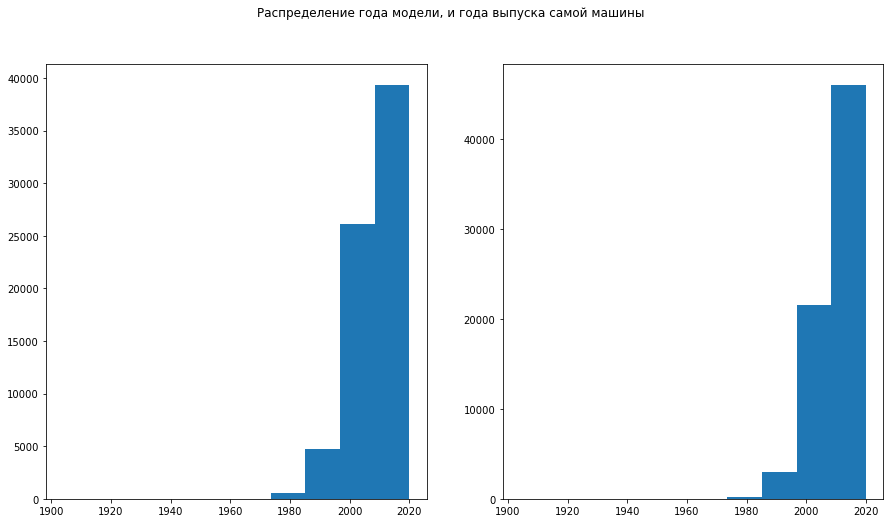

In [5]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.hist(df.modelDate)
ax2.hist(df.productionDate)
figure.suptitle('Распределение года модели, и года выпуска самой машины')
plt.show()

In [17]:
df['diff_date_model_production'] = df.productionDate-df.modelDate
df['diff_date_model_production_log'] = np.log(df.diff_date_model_production-np.min(df.diff_date_model_production)+1)

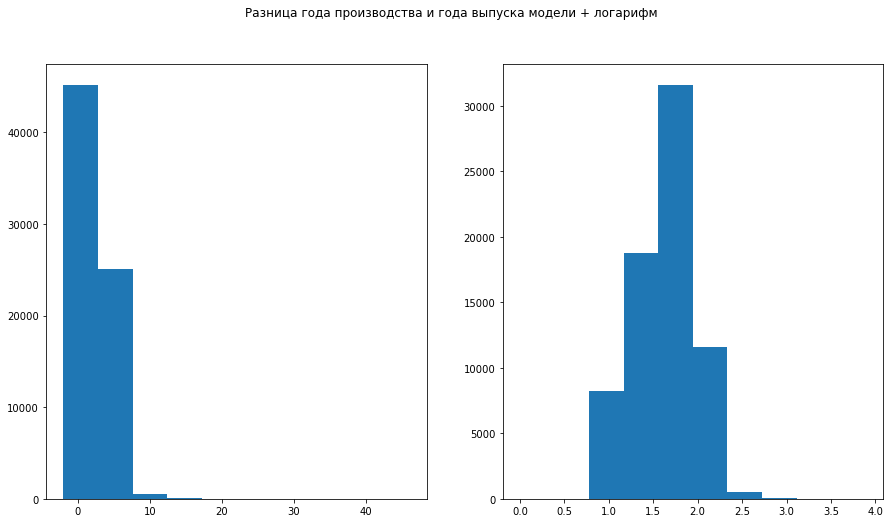

In [19]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.hist(df.diff_date_model_production)
ax2.hist(df.diff_date_model_production_log)
figure.suptitle('Разница года производства и года выпуска модели + логарифм')
plt.show();

## Владельцы

заменим категориальную переменну числом, ведь это ординальная ,3 владельца болье чем 2 и 2 больше чем 1  
но что ставить когда неизвестно! если пробег 0, то и владельцев 0  
а если пробег больше 0 то ставим 2 владельца - как среднее в нашей выборке  


In [33]:
df['Владельцы'].value_counts()

3 или более    29078
1 владелец     18197
2 владельца    17001
Неизвестно      6620
Name: Владельцы, dtype: int64

In [34]:
df['Владельцы'].unique()

array(['3 или более', '1\xa0владелец', '2\xa0владельца', 'Неизвестно'],
      dtype=object)

In [35]:
df[df['Владельцы'] == 'Неизвестно'].mileage.value_counts()

0         6616
130000       1
160000       1
119000       1
280000       1
Name: mileage, dtype: int64

In [36]:
mask = (df['Владельцы'] == 'Неизвестно') & (df.mileage == 0)
df.loc[mask, 'Владельцы'] = "Новая машина"
mask = (df['Владельцы'] == 'Неизвестно') & (df.mileage != 0)
df.loc[mask, 'Владельцы'] = "2\xa0владельца"

In [37]:
df['Владельцы'].value_counts()

3 или более     29078
1 владелец      18197
2 владельца     17005
Новая машина     6616
Name: Владельцы, dtype: int64

In [38]:
df['Владельцы'].unique()

array(['3 или более', '1\xa0владелец', '2\xa0владельца', 'Новая машина'],
      dtype=object)

In [39]:
owners_map = {
    'Новая машина':0,
    '1\xa0владелец':1,
    '2\xa0владельца':2,
    '3 или более':3    
}
df['owners'] = df['Владельцы'].map(owners_map)

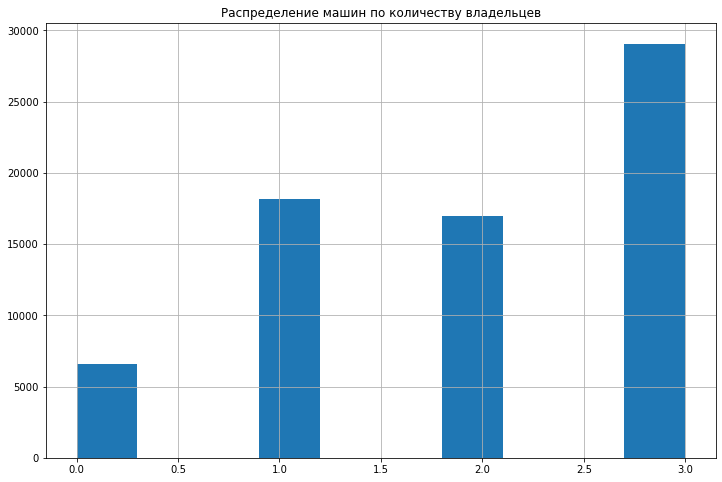

In [40]:
df.owners.hist();
plt.title('Распределение машин по количеству владельцев');

## Владение

много пропущенных значений, больше половины набора данных  
сделаем колонку что срок владения укзаан, и больше ничего не будем делать  

In [41]:
print(f"процент пропущенных значений: {df['Владение'].isna().sum() / df.shape[0]}")

процент пропущенных значений: 0.699291920559693


In [42]:
df['Владение'].value_counts()

1 год и 10 месяцев             209
2 года                         197
1 год                          194
1 год и 1 месяц                193
1 год и 2 месяца               187
                              ... 
{'year': 1994, 'month': 6}       1
23 года и 9 месяцев              1
24 года и 2 месяца               1
18 лет и 10 месяцев              1
{'year': 2004, 'month': 10}      1
Name: Владение, Length: 538, dtype: int64

In [43]:
df['own_time_is_na'] = df['Владение'].isna()

## Оформим все в одну функцию

In [8]:
def feature_enginering_version2(df: pd.DataFrame):
    """запишем сюда все преобразования которые делали в этом разделе ноутбука
    1) В колонке model_name_cut все редкие модели (не в ТОП 50) заменяем на RARE_MODEL
    2) добавляем колонки diff_date_model_production и diff_date_model_production_log
    3) добавляем порядковую колонку owners
    4) добавляем колонку own_time_is_na"""
    
    df.model_name = df.model_name.str.replace(' ', '_')
    
    df['model_name_cut_50'] = df.model_name
    top_models = df.model_name.value_counts()[:50].index
    df.loc[~df.model_name.isin(top_models), 'model_name_cut_50'] = 'RARE_MODEL'
    
    df['model_name_cut_450'] = df.model_name
    top_models = df.model_name.value_counts()[:450].index
    df.loc[~df.model_name.isin(top_models), 'model_name_cut_450'] = 'RARE_MODEL'
    
    df['diff_date_model_production'] = df.productionDate-df.modelDate
    df['diff_date_model_production_log'] = np.log(df.diff_date_model_production-np.min(df.diff_date_model_production)+1)
    
    mask = (df['Владельцы'] == 'Неизвестно') & (df.mileage == 0)
    df.loc[mask, 'Владельцы'] = "Новая машина"
    mask = (df['Владельцы'] == 'Неизвестно') & (df.mileage != 0)
    df.loc[mask, 'Владельцы'] = "2\xa0владельца"
    
    owners_map = {
        'Новая машина':0,
        '1\xa0владелец':1,
        '2\xa0владельца':2,
        '3 или более':3    
    }
    df['owners'] = df['Владельцы'].map(owners_map)
    
    df['own_time_is_na'] = df['Владение'].isna()

In [9]:
feature_enginering_version2(df)

## Попробуем новые признаки в предсказании

In [50]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols = ['productionDate', 'numberOfDoors',
            'enginePower_log', 'mileage_log', ]


X_train, X_test, y = prepare_data(cat_cols, num_cols)

In [15]:
model = RandomForestRegressor(100, random_state=RANDOM_STATE)

In [52]:
%%time
fit_and_score_model(model, X_train, y)

####################################################################################################
RandomForestRegressor(random_state=43)
train shape (36210, 744)
cat_cols=['bodyType', 'brand', 'fuelType', 'color', 'model_name', 'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols=['productionDate', 'numberOfDoors', 'enginePower_log', 'mileage_log']
####################################################################################################
Train result: 5.573685792860849
CV result: 14.092390584403361 ([13.98608792 14.4967602  13.79432364])
####################################################################################################
Wall time: 3min 42s


Очистка поля **model_name** помогла. Это уже улучшило нашу модель на 0.01 и уменьшило количество колонок на 40.

### model_name_cut

In [24]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name_cut_50',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols = ['productionDate', 'numberOfDoors',
            'enginePower_log', 'mileage_log', ]


X_train, X_test, y = prepare_data(cat_cols, num_cols)

In [25]:
%%time
fit_and_score_model(model, X_train, y)

####################################################################################################
RandomForestRegressor(random_state=43)
train shape (36210, 130)
cat_cols=['bodyType', 'brand', 'fuelType', 'color', 'model_name_cut_50', 'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols=['productionDate', 'numberOfDoors', 'enginePower_log', 'mileage_log']
####################################################################################################
Train result: 5.969417669066359
CV result: 15.205308348229726 ([15.12644352 15.56449013 14.92499139])
####################################################################################################
Wall time: 1min 26s


Точность сильно упала, но зато в два раза уменьшилось время обучения, и число признаков сократилось до 130.  
Но за скоростью мы не гонимся, поэтому этот признак не используем.  

Может взять больше моделей, 450 а не 50 ...

In [57]:
df.model_name = df.model_name.str.replace(' ', '_')
top_models = df.model_name.value_counts()[:450].index
df['model_name_cut'] = df.model_name
df.loc[~df.model_name.isin(top_models), 'model_name_cut'] = 'RARE_MODEL'



In [26]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name_cut_450',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols = ['productionDate', 'numberOfDoors',
            'enginePower_log', 'mileage_log', ]


X_train, X_test, y = prepare_data(cat_cols, num_cols)

In [27]:
%%time
fit_and_score_model(model, X_train, y)

####################################################################################################
RandomForestRegressor(random_state=43)
train shape (36210, 530)
cat_cols=['bodyType', 'brand', 'fuelType', 'color', 'model_name_cut_450', 'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols=['productionDate', 'numberOfDoors', 'enginePower_log', 'mileage_log']
####################################################################################################
Train result: 5.631875243356286
CV result: 14.352788226369746 ([14.06591381 14.70679025 14.28566062])
####################################################################################################
Wall time: 2min 52s


В результате поле **model_name_cut** не дало никакого прироста в точности прогноза, поэтому его не испльзуем.

### diff_date

In [28]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols = ['productionDate', 'numberOfDoors',
            'enginePower_log', 'mileage_log', 'diff_date_model_production_log']


X_train, X_test, y = prepare_data(cat_cols, num_cols)

In [29]:
%%time
fit_and_score_model(model, X_train, y)

####################################################################################################
RandomForestRegressor(random_state=43)
train shape (36210, 745)
cat_cols=['bodyType', 'brand', 'fuelType', 'color', 'model_name', 'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols=['productionDate', 'numberOfDoors', 'enginePower_log', 'mileage_log', 'diff_date_model_production_log']
####################################################################################################
Train result: 5.55774193832088
CV result: 14.041206371628798 ([13.89005779 14.3894928  13.84406852])
####################################################################################################
Wall time: 3min 54s


Показатель **diff_date** годный. Он хорошо улучшил нашу модель. Берем его.

### owners

In [31]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols = ['productionDate', 'numberOfDoors',
            'enginePower_log', 'mileage_log', 'diff_date_model_production_log', 'owners']


X_train, X_test, y = prepare_data(cat_cols, num_cols)

In [32]:
%%time
fit_and_score_model(model, X_train, y)

####################################################################################################
RandomForestRegressor(random_state=43)
train shape (36210, 746)
cat_cols=['bodyType', 'brand', 'fuelType', 'color', 'model_name', 'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols=['productionDate', 'numberOfDoors', 'enginePower_log', 'mileage_log', 'diff_date_model_production_log', 'owners']
####################################################################################################
Train result: 5.5564692160094085
CV result: 14.027312138856653 ([13.84501638 14.35060777 13.88631227])
####################################################################################################
Wall time: 3min 34s


Отлично, **owners** еще немного улучшили предсказание.  
Берем этот признак!

### own_time_is_na

In [33]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols = ['productionDate', 'numberOfDoors',
            'enginePower_log', 'mileage_log', 'diff_date_model_production_log', 'owners', 'own_time_is_na']


X_train, X_test, y = prepare_data(cat_cols, num_cols)

In [34]:
%%time
fit_and_score_model(model, X_train, y)

####################################################################################################
RandomForestRegressor(random_state=43)
train shape (36210, 747)
cat_cols=['bodyType', 'brand', 'fuelType', 'color', 'model_name', 'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols=['productionDate', 'numberOfDoors', 'enginePower_log', 'mileage_log', 'diff_date_model_production_log', 'owners', 'own_time_is_na']
####################################################################################################
Train result: 5.546883394630141
CV result: 14.058894697319205 ([13.89439214 14.38828568 13.89400627])
####################################################################################################
Wall time: 3min 48s


Признак **own_time_is_na** не помог

## Выводы после feature enginering

- price_log - плохо
- bodyType_cut - плохо
- engine_power_log - **хорошо**
- mileage_log - **хорошо**
- mileage_is_0 - плохо
- model_name_cut - плохо
- diff_date_model_production - **хорошо**
- owners - *хорошо*
- own_time_is_na - плохо

In [11]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols = ['productionDate', 'numberOfDoors',
            'enginePower_log', 'mileage_log', 'diff_date_model_production_log', 'owners']


X_train, X_test, y = prepare_data(cat_cols, num_cols)

# Генерируем новые фичи из дополнительных колонок

Есть 5 дополнительных полей, из которых можно генерировать новые фичи, но нужно их анализировать

In [11]:
df[['description','complectation_dict','equipment_dict','model_info','super_gen']].head()

,description,complectation_dict,equipment_dict,model_info,super_gen
0,"Все автомобили, представленные в продаже, прох...",NaN,"{""engine-proof"":true,""tinted-glass"":true,""airb...","{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...","{""id"":""10373605"",""displacement"":1197,""engine_t..."
1,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,NaN,"{""cruise-control"":true,""asr"":true,""esp"":true,""...","{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...","{""id"":""20913311"",""displacement"":1598,""engine_t..."
2,"Все автомобили, представленные в продаже, прох...","{""id"":""20026336"",""name"":""Ambition"",""available_...","{""cruise-control"":true,""tinted-glass"":true,""es...","{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...","{""id"":""20026323"",""nameplate"":""DSG"",""displaceme..."
3,КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,"{""id"":""20803582"",""name"":""Ambition"",""available_...","{""cruise-control"":true,""roller-blind-for-rear-...","{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...","{""id"":""20105521"",""displacement"":1598,""engine_t..."
4,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,NaN,"{""cruise-control"":true,""asr"":true,""esp"":true,""...","{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...","{""id"":""4561004"",""displacement"":1798,""engine_ty..."


## equipment_dict

In [12]:
df[['equipment_dict','is_train']].sample().values

array([["{'engine-proof': True, 'alloy-wheel-disks': True, '16-inch-wheels': True, 'ptf': True, 'eco-leather': True, 'airbag-driver': True, 'aux': True, 'electro-window-front': True, 'body-mouldings': True, 'ashtray-and-cigarette-lighter': True, 'passenger-seat-updown': True, 'airbag-passenger': True, 'front-centre-armrest': True, 'condition': True, 'front-seats-heat': True, 'roof-rails': True, 'seat-transformation': True, 'wheel-leather': True, 'light-interior': True, 'lock': True, '12v-socket': True, 'third-rear-headrest': True, 'drl': True}",
        True]], dtype=object)

В поле содержится json или python dict (я в трейне так спарсил).
В этом объекте содержится значений опций присутствующих у авто. если значения нет, то и опция у машины не указана
Можно из каждой опции сделать отдельную колонку бинарную.
правда есть проблема, если вообще у колонки не указаны опции вообще, то и эта конкретная не известно есть или нет.
Возможно имеет смысле ввести 3 значения: опция есть, опции указаны и этой опции нет, опции вообще не указаны. Но я это делать не буду.
И так в наборе очень много колонок получается, и очень долго тренирутся модель.



###  Сделаем функции которые создают бинарный dataframe из колонок json

In [12]:
def parse_dict_column(row, column_name):
    """Функция парсит значение в ячейке.
    Если это train строка то применяет функцию eval
    Если это test - то загружает методом json.loads
    Возвращает dict полученный из строкового представления.
    Или возвращает None если значение не указано, или словарь пустой"""
    if row[column_name] is np.nan:
        value = None
    elif row.is_train:
        value = eval(row[column_name])
    else:
        value = json.loads(row[column_name])
    
    return value if value else None

def create_dataframe_from_json_column(column_name):
    """Создает датафрейм из колонки, в которой храняться json(dict) параметров автомобиля """
    series_ = df.apply(partial(parse_dict_column, column_name=column_name), axis=1)
    dataframe_ = series_.apply(pd.Series)
    return dataframe_

### Работаем с колонкой

In [14]:
equipment_dataframe = create_dataframe_from_json_column('equipment_dict')
equipment_dataframe.fillna(False, inplace=True)

In [15]:
equipment_dataframe.head()

,engine-proof,tinted-glass,airbag-driver,aux,isofix,electro-window-front,ashtray-and-cigarette-lighter,airbag-passenger,computer,high-beam-assist,...,61U,PRG,597,3S1,CJ4,239,3PB,313,42D,PRA
0,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
1,False,False,True,False,True,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
2,True,True,True,True,True,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
3,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
4,False,False,True,False,True,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False


Получили большой набор из бинарных колонок, попробуем добавить его так к нашему набору, и попробовать прогнозировать на нем

In [15]:
df_origin = df.copy() # сохраним оригинальный df чтобы переделывать далее

In [17]:
df = pd.concat([df_origin, equipment_dataframe], axis=1)

### Пробуем новые признаки в предсказании

In [18]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль'] 
num_cols = ['productionDate', 'numberOfDoors',
            'enginePower_log', 'mileage_log', 'diff_date_model_production'] + list(equipment_dataframe.columns.values)

X_train, X_test, y = prepare_data(cat_cols, num_cols)

In [19]:
model = RandomForestRegressor(100, random_state=RANDOM_STATE)

In [20]:
%%time
fit_and_score_model(model, X_train, y)

####################################################################################################
RandomForestRegressor(random_state=43)
train shape (36210, 1069)
cat_cols=['bodyType', 'brand', 'fuelType', 'color', 'model_name', 'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols=['productionDate', 'numberOfDoors', 'enginePower_log', 'mileage_log', 'diff_date_model_production', 'engine-proof', 'tinted-glass', 'airbag-driver', 'aux', 'isofix', 'electro-window-front', 'ashtray-and-cigarette-lighter', 'airbag-passenger', 'computer', 'high-beam-assist', 'seat-transformation', 'isofix-front', 'wheel-power', 'alarm', 'lock', 'door-sill-panel', 'fabric-seats', 'electro-mirrors', 'airbag-rear-side', 'electro-window-back', 'steel-wheels', 'ptf', '16-inch-wheels', 'rain-sensor', 'airbag-side', 'audiosystem-cd', 'dark-interior', 'cooling-box', 'condition', 'abs', 'power-child-locks-rear-doors', 'front-seats-heat', 'wheel-configuration2', 'wheel-configuration1', '12v

фичи новые принесли пользу, без них лучшим результатом были 14.03  
но уж очень долго тренируется с таким количеством фич тренировка
посмотрим те, что принесли пользу и возмем только несколько из них  
т.к на тренировки модели на 2000 деревьев я буду очень долго ждать

### Возьмем только ТОПовые фичи

In [21]:
def get_top_features(model, train_columns, filter_columns, num_top_features):
    top_features_ = pd.Series(model.feature_importances_,
          index=train_columns).sort_values(ascending=False).index
    top_features_ = top_features_[top_features_.isin(filter_columns)]
    top_features_ = filter_columns[:num_top_features]
    return list(top_features_)

In [22]:
get_top_features(model, X_train.columns, equipment_dataframe.columns, 10)

['engine-proof',
 'tinted-glass',
 'airbag-driver',
 'aux',
 'isofix',
 'electro-window-front',
 'ashtray-and-cigarette-lighter',
 'airbag-passenger',
 'computer',
 'high-beam-assist']

In [27]:
top_faetures = get_top_features(model, X_train.columns, equipment_dataframe.columns, 100)

In [24]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль'] 
num_cols = ['productionDate', 'numberOfDoors',
            'enginePower_log', 'mileage_log', 'diff_date_model_production'] + top_faetures

X_train, X_test, y = prepare_data(cat_cols, num_cols)

In [25]:
%%time
fit_and_score_model(model, X_train, y)

####################################################################################################
RandomForestRegressor(random_state=43)
train shape (36210, 845)
cat_cols=['bodyType', 'brand', 'fuelType', 'color', 'model_name', 'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols=['productionDate', 'numberOfDoors', 'enginePower_log', 'mileage_log', 'diff_date_model_production', 'engine-proof', 'tinted-glass', 'airbag-driver', 'aux', 'isofix', 'electro-window-front', 'ashtray-and-cigarette-lighter', 'airbag-passenger', 'computer', 'high-beam-assist', 'seat-transformation', 'isofix-front', 'wheel-power', 'alarm', 'lock', 'door-sill-panel', 'fabric-seats', 'electro-mirrors', 'airbag-rear-side', 'electro-window-back', 'steel-wheels', 'ptf', '16-inch-wheels', 'rain-sensor', 'airbag-side', 'audiosystem-cd', 'dark-interior', 'cooling-box', 'condition', 'abs', 'power-child-locks-rear-doors', 'front-seats-heat', 'wheel-configuration2', 'wheel-configuration1', '12v-

In [26]:
df = df_origin

In [27]:
make_submit_file(model, X_test, "2_features_from_equipment_dict_random_forest_100.csv")

Результат в лидерборде: **12.99**

## complectation_dict

In [32]:
complectation_dataframe = create_dataframe_from_json_column('complectation_dict')

In [34]:
complectation_dataframe.head()

,id,name,available_options,vendor_colors
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,20026336,Ambition,"[heated-wash-system, airbag-passenger, lock, d...",NaN
3,20803582,Ambition,"[heated-wash-system, airbag-passenger, lock, e...","[{'body_color_id': 20625189, 'mark_color_id': ..."
4,NaN,NaN,NaN,NaN


In [39]:
complectation_dataframe.isna().sum()/complectation_dataframe.shape[0]

id                  0.40
name                0.73
available_options   0.74
vendor_colors       0.84
dtype: float64

Очень много пропусков, поэтому я не думаю что стоит брать из этой информации какие-то новые фичи

## model_info

In [40]:
model_dataframe = create_dataframe_from_json_column('model_info')

In [43]:
model_dataframe.sample(10)

,code,name,ru_name,morphology,nameplate
57958,CLA_KLASSE,CLA,ЦЛА-класс,{},"{'code': '9264600', 'name': '250', 'semantic_u..."
61406,GL_KLASSE,GL-Класс,GL-класс,{},"{'code': '9264835', 'name': '350', 'semantic_u..."
44695,MURANO,Murano,Мурано,{},"{'code': '', 'name': '', 'semantic_url': ''}"
54486,TOUAREG,Touareg,Туарег,{},"{'code': '', 'name': '', 'semantic_url': ''}"
14443,ALMERA,Almera,Альмера,{},"{'code': '', 'name': '', 'semantic_url': ''}"
63374,LANCER,Lancer,Лансер,{},"{'code': '', 'name': '', 'semantic_url': ''}"
19544,HIGHLANDER,Highlander,Хайлендер,{},"{'code': '', 'name': '', 'semantic_url': ''}"
1641,OCTAVIA,Octavia,Октавия,{'gender': 'FEMININE'},"{'code': '', 'name': '', 'semantic_url': ''}"
21839,COROLLA,Corolla,Королла,{'gender': 'FEMININE'},"{'code': '', 'name': '', 'semantic_url': ''}"
23166,PASSAT_CC,Passat CC,Пассат СС,{},"{'code': '', 'name': '', 'semantic_url': ''}"


Информация не кажется полезной.  
Не будем ее использовать тоже

## super_gen

In [48]:
gen_dataframe = create_dataframe_from_json_column('super_gen')

In [50]:
gen_dataframe.sample(10)

,id,displacement,engine_type,gear_type,transmission,power,power_kvt,human_name,acceleration,clearance_min,fuel_rate,nameplate,clearance_max,name,ru_name,year_from,year_to,price_segment
29262,20158772,"2,993.00",DIESEL,ALL_WHEEL_DRIVE,AUTOMATIC,249.00,183.00,30d 3.0d AT (249 л.с.) 4WD,6.70,212.00,6.00,30d,nan,30d,NaN,nan,nan,NaN
22396,20494803,"1,598.00",GASOLINE,FORWARD_CONTROL,ROBOT,124.00,91.00,1.6 AMT (124 л.с.),12.10,150.00,6.90,NaN,nan,NaN,NaN,nan,nan,NaN
16901,8333074,"2,987.00",DIESEL,ALL_WHEEL_DRIVE,AUTOMATIC,211.00,155.00,350 CDI BlueTEC 3.0d AT (211 л.с.) 4WD,9.10,205.00,11.20,350 CDI BlueTEC,nan,350,NaN,nan,nan,NaN
49314,9259583,nan,NaN,NaN,NaN,nan,nan,NaN,nan,nan,nan,NaN,nan,"IV (W212, S212, C207) Рестайлинг","4 (W212, S212, C207) Рестайлинг","2,013.00","2,016.00",PREMIUM
27304,20501398,"1,968.00",DIESEL,ALL_WHEEL_DRIVE,MECHANICAL,140.00,103.00,2.0d MT (140 л.с.) 4WD,10.80,200.00,6.70,NaN,nan,NaN,NaN,nan,nan,NaN
44155,3493042,nan,NaN,NaN,NaN,nan,nan,NaN,nan,nan,nan,NaN,nan,I,1,"1,998.00","2,003.00",PREMIUM
38858,7770222,nan,NaN,NaN,NaN,nan,nan,NaN,nan,nan,nan,NaN,nan,IX Рестайлинг,NaN,"2,005.00","2,010.00",MEDIUM
49605,20089956,nan,NaN,NaN,NaN,nan,nan,NaN,nan,nan,nan,NaN,nan,IV (W205),4 (W205),"2,014.00","2,018.00",PREMIUM
27940,6283500,"1,798.00",GASOLINE,FORWARD_CONTROL,VARIATOR,140.00,103.00,1.8 CVT (140 л.с.),13.10,195.00,7.60,NaN,nan,NaN,NaN,nan,nan,NaN
39663,20898195,nan,NaN,NaN,NaN,nan,nan,NaN,nan,nan,nan,NaN,nan,III (A7) Рестайлинг,3 Рестайлинг,"2,017.00",nan,MEDIUM


In [57]:
gen_dataframe.isna().sum()

id                   0
displacement     36210
engine_type      36210
gear_type        36210
transmission     36210
power            36210
power_kvt        36210
human_name       36210
acceleration     38155
clearance_min    37161
fuel_rate        39686
nameplate        60190
clearance_max    70300
name             25492
ru_name          37555
year_from        34686
year_to          43739
price_segment    34686
dtype: int64

In [60]:
gen_dataframe

,id,displacement,engine_type,gear_type,transmission,power,power_kvt,human_name,acceleration,clearance_min,fuel_rate,nameplate,clearance_max,name,ru_name,year_from,year_to,price_segment
0,10373605,"1,197.00",GASOLINE,FORWARD_CONTROL,ROBOT,105.00,77.00,1.2 AMT (105 л.с.),10.50,155.00,5.00,NaN,nan,NaN,NaN,nan,nan,NaN
1,20913311,"1,598.00",GASOLINE,FORWARD_CONTROL,MECHANICAL,110.00,81.00,1.6 MT (110 л.с.),10.80,156.00,6.40,NaN,nan,NaN,NaN,nan,nan,NaN
2,20026323,"1,798.00",GASOLINE,FORWARD_CONTROL,ROBOT,152.00,112.00,DSG 1.8 AMT (152 л.с.),8.70,139.00,7.10,DSG,158.00,NaN,NaN,nan,nan,NaN
3,20105521,"1,598.00",GASOLINE,FORWARD_CONTROL,AUTOMATIC,110.00,81.00,1.6 AT (110 л.с.),12.20,155.00,6.70,NaN,nan,NaN,NaN,nan,nan,NaN
4,4561004,"1,798.00",GASOLINE,FORWARD_CONTROL,AUTOMATIC,152.00,112.00,1.8 AT (152 л.с.),8.80,164.00,7.70,NaN,nan,NaN,NaN,nan,nan,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70891,20183736,nan,NaN,NaN,NaN,nan,nan,NaN,nan,nan,nan,NaN,nan,I (4G) Рестайлинг,1 (4G) Рестайлинг,"2,014.00","2,018.00",PREMIUM
70892,21210593,nan,NaN,NaN,NaN,nan,nan,NaN,nan,nan,nan,NaN,nan,V (C8),5 (С8),"2,018.00",nan,PREMIUM
70893,6457121,nan,NaN,NaN,NaN,nan,nan,NaN,nan,nan,nan,NaN,nan,I (4G),1 (4G),"2,010.00","2,014.00",PREMIUM
70894,7754720,nan,NaN,NaN,NaN,nan,nan,NaN,nan,nan,nan,NaN,nan,IV (B8) Рестайлинг,4 (B8) Рестайлинг,"2,011.00","2,016.00",PREMIUM


Интересно, в тренировочном наборе это поле не заполнено полностью. Поэтому нет возможности исползовать это поле.  
Но можно доработать парсер, чтобы это поле собиралось с сайте.


## Оформим все в функции

In [10]:
def parse_dict_column(row, column_name):
    """Функция парсит значение в ячейке.
    Если это train строка то применяет функцию eval
    Если это test - то загружает методом json.loads
    Возвращает dict полученный из строкового представления.
    Или возвращает None если значение не указано, или словарь пустой"""
    if row[column_name] is np.nan:
        value = None
    elif row.is_train:
        value = eval(row[column_name])
    else:
        value = json.loads(row[column_name])
    
    return value if value else None

def create_dataframe_from_json_column(df, column_name):
    """Создает датафрейм из колонки, в которой храняться json(dict) параметров автомобиля """
    series_ = df.apply(partial(parse_dict_column, column_name=column_name), axis=1)
    dataframe_ = series_.apply(pd.Series)
    return dataframe_

def get_top100_equipment_features():
    return [
        'engine-proof', 'tinted-glass', 'airbag-driver', 'aux', 'isofix',
        'electro-window-front', 'ashtray-and-cigarette-lighter',
        'airbag-passenger', 'computer', 'high-beam-assist', 'seat-transformation',
        'isofix-front', 'wheel-power', 'alarm', 'lock', 'door-sill-panel',
        'fabric-seats', 'electro-mirrors', 'airbag-rear-side',
        'electro-window-back', 'steel-wheels', 'ptf', '16-inch-wheels',
        'rain-sensor', 'airbag-side', 'audiosystem-cd', 'dark-interior',
        'cooling-box', 'condition', 'abs', 'power-child-locks-rear-doors',
        'front-seats-heat', 'wheel-configuration2', 'wheel-configuration1',
        '12v-socket', 'park-assist-r', 'cruise-control', 'asr', 'esp', 'usb',
        'light-sensor', 'drl', 'alloy-wheel-disks', 'tyre-pressure',
        'mirrors-heat', 'driver-seat-updown', 'wheel-heat', 'bluetooth', 'immo',
        'windscreen-heat', 'climate-control-2', 'adaptive-light', 'multi-wheel',
        'xenon', 'heated-wash-system', 'front-centre-armrest', 'body-mouldings',
        'combo-interior', 'rear-seats-heat', 'knee-airbag', 'hcc',
        'airbag-curtain', 'light-cleaner', 'leather-gear-stick', 'wheel-leather',
        'auto-mirrors', 'third-rear-headrest', 'roller-blind-for-rear-window',
        'spare-wheel', 'navigation', 'folding-front-passenger-seat',
        'programmed-block-heater', 'passenger-seat-updown', 'sport-seats',
        'front-seat-support', '18-inch-wheels', 'volume-sensor', 'hatch',
        'music-super', 'automatic-lighting-control', 'paint-metallic',
        'climate-control-1', 'roof-rails', '17-inch-wheels', 'sport-pedals', 'gbo',
        'park-assist-f', 'feedback-alarm', 'passenger-seat-electric', 'leather',
        'electro-trunk', 'driver-seat-memory', 'keyless-entry', 'rear-camera',
        'led-lights', '15-inch-wheels', 'audiosystem-tv', 'seats-7', 'auto-park',
        'apple-carplay'
    ]

def feature_enginering_add_equipment_features(df):
    """Сгенерируем новые фичи из колонки equipment_dict, возмьмем не все а ТОП 100 признаков"""
    
    equipment_dataframe = create_dataframe_from_json_column(df, 'equipment_dict')
    equipment_dataframe.fillna(False, inplace=True)
    
    return pd.concat([df, equipment_dataframe[get_top100_equipment_features()]],
          axis=1)

In [11]:
%%time
df = feature_enginering_add_equipment_features(df)

Wall time: 1min 33s


In [12]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль'] 
num_cols = ['productionDate', 'numberOfDoors',
            'enginePower_log', 'mileage_log', 'diff_date_model_production'] + get_top100_equipment_features()

## Выводы

Пользу смогли извлечь только из колонки **equipment dict**  
Еще может быть могла бы помочь колонка `super_gen`, но ее плохо спарсили для трейн набора, поэтому ее не используем.

# Генерация колонок из текстового описания объявления

`description` текстовое поле. И нужно обрабатывать его, и вытащить из него ряд фичей
Известные методы:
- удалить знаки препинания и стоп слова
- bag of words
- tf/idf

In [4]:
df.description

0        Все автомобили, представленные в продаже, прох...
1        ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...
2        Все автомобили, представленные в продаже, прох...
3        КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...
4        ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...
                               ...                        
70891       Машина идеальном состоянии не бити не крашеный
70892    Мы ждем Вашего звонка, чтобы предложить лучшие...
70893    Продаётся идеальный автомобиль, весь в родном ...
70894    Масло не ест. Мотор после ремонта ( пробег пос...
70895    Автомобиль приобретался у официального дилера ...
Name: description, Length: 70896, dtype: object

## Удалим знаки препинания и стоп слова

In [14]:
def remove_uppercase_and_punctuation(serie: pd.Series):
    """Переводит текстовую колонку в нижний регистр и удаляет знаки препинания"""
    punct = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{}~'   # `|` is not present here
    transtab = str.maketrans(dict.fromkeys(punct, ''))
    
    serie = serie.str.lower().str.replace("|","").fillna('')
    return pd.Series('|'.join(serie.tolist()).translate(transtab).split('|'))

In [15]:
df.description = remove_uppercase_and_punctuation(df.description)

## Мешок слов

Попробуем делать подсчет кадого слова в описании.

In [16]:
%%time
count = CountVectorizer(stop_words=stopwords.words("russian"))
bag_of_words = count.fit_transform(df.description)

Wall time: 9.5 s


In [18]:
bag_of_words

<70896x141152 sparse matrix of type '<class 'numpy.int64'>'
	with 5661663 stored elements in Compressed Sparse Row format>

Теперь нужно объединить наш исходный набор данных и "мешок слов".  
Преобразуем его в `SparseDataFrame` и передадим функции `prepare_data`

## Пробуем предсказать что-то с помощью мешка слов

Преобразуем данные из прошлого этапа "вручную", без использования функции

In [18]:
X = df.loc[:, cat_cols+num_cols+['is_train']]

X = pd.get_dummies(X, columns=cat_cols)

X[num_cols] = StandardScaler().fit_transform(X[num_cols])


In [22]:
sparse_df = hstack(
    [X.values.astype('float'), 
     bag_of_words
    ]).tocsr()

In [23]:
X_train = sparse_df[df.is_train == 1]
X_test = sparse_df[df.is_train == 0]
y = df.price[df.is_train == 1]

Будем делать проверку просто на отложеной выборке (чтобы не ждать слишком долго)

In [24]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y, test_size=0.3, shuffle=True, random_state=RANDOM_STATE)

In [28]:
X_train.shape

(25347, 141998)

Модель **RandomForestRegressor** тренировалась больше двух часов, и я решил ее не использовать

In [25]:
#model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
model = Lasso()

In [26]:
%%time
model.fit(X_train, y_train)

Wall time: 1h 11min 37s


C:\Soft\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 607110820598534.8, tolerance: 13191435323833.654
  model = cd_fast.sparse_enet_coordinate_descent(


Lasso()

In [27]:
pred = model.predict(X_val)
score = mape(pred, y_val)
print(f"MAPE: {score}")


MAPE: 585.1864120524156


Ну вобщем можно сказать что влоб применить данные из текстового описания не получилось.  
Модель тренируется ну очень долго, и показала очень плохой результат.  

Знаю, что есть способ вытащить выжные фичи из описания, но пока у меня не получилось.

## TF-IDF

In [29]:
%%time
count = TfidfVectorizer(stop_words=stopwords.words("russian"))
tf_idf = count.fit_transform(df.description)

Wall time: 10.5 s


In [30]:
tf_idf.shape

(70896, 141152)

## Выводы

У меня не получилос использовать данные из колонким `description`. С ними модель очень долго считает, и применение их просто так как мешок слов не дало хорошего резултата.

Я пропускаю эту колонку.

# Выводы

В результате этого этапа мы добавили новые признаки в модель.  
Эти признаки улучшили качество предсказания на 1%.  

Засабмитим еще раз на kaggle.

In [13]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль'] 
num_cols = ['productionDate', 'numberOfDoors',
            'enginePower_log', 'mileage_log', 'diff_date_model_production'] + get_top100_equipment_features()

In [14]:
X_train, X_test, y = prepare_data(cat_cols, num_cols)

In [15]:
model = RandomForestRegressor(100, random_state=RANDOM_STATE)

In [16]:
%%time
fit_and_score_model(model, X_train, y)

####################################################################################################
RandomForestRegressor(random_state=43)
train shape (36210, 845)
cat_cols=['bodyType', 'brand', 'fuelType', 'color', 'model_name', 'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols=['productionDate', 'numberOfDoors', 'enginePower_log', 'mileage_log', 'diff_date_model_production', 'engine-proof', 'tinted-glass', 'airbag-driver', 'aux', 'isofix', 'electro-window-front', 'ashtray-and-cigarette-lighter', 'airbag-passenger', 'computer', 'high-beam-assist', 'seat-transformation', 'isofix-front', 'wheel-power', 'alarm', 'lock', 'door-sill-panel', 'fabric-seats', 'electro-mirrors', 'airbag-rear-side', 'electro-window-back', 'steel-wheels', 'ptf', '16-inch-wheels', 'rain-sensor', 'airbag-side', 'audiosystem-cd', 'dark-interior', 'cooling-box', 'condition', 'abs', 'power-child-locks-rear-doors', 'front-seats-heat', 'wheel-configuration2', 'wheel-configuration1', '12v-

In [17]:
make_submit_file(model, X_test, "3_predict_after_feature_enginering.csv")

**RandomForestRegressor(random_state=43)**  
CV mean_result: 13.85  
train mape 5.02  
kaggle submit 12.99

В результате работы мы смогли сгенерировать новые фичи и улучшить качество нашей модели.  


# Сохраним данные, для следующего ноутбука

In [18]:
df.to_csv('data2.csv')

# В следующем этапе

- Попробовать другие модели на этом наборе данных (xgboost, catboost)
- Настраивать параметры моделей
- Стекинг, Ансамбли